# Ejercicio 2

## Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

from scipy.stats import norm

N = norm.cdf

from scipy.optimize import fsolve
from scipy import optimize

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

Función gráfico 3D

In [0]:
def plot_3D(data):

  enable_plotly_in_cell()


  data = [
      go.Surface(
          z=data.T
      )
  ]
  layout = go.Layout(
      title='Option price',
      autosize=False,
      width=500,
      height=500,
      margin=dict(
          l=65,
          r=50,
          b=65,
          t=90
      )
  )
  fig = go.Figure(data=data, layout=layout)
  iplot(fig, filename='elevations-3d-surface')

Función que calcula la matriz para la resolución de las PDEs

In [0]:
def compute_M_matrix(time_grid, x_grid, time_grid_index, drift_functor, var_functor, disc_functor):
  
  # Assumes a regular x_grid
  
  M = np.zeros((len(x_grid)-2, len(x_grid)-2))
  
  inv_delta_x = 1/(x_grid[1]-x_grid[0])
  
  inv_delta_x_squared = inv_delta_x * inv_delta_x 
  
  
  delta_t = time_grid[1]-time_grid[0]
  
  rho = delta_t * inv_delta_x
  alpha = delta_t *  inv_delta_x_squared
  
  t = time_grid[time_grid_index]
  
  
  for i in range(len(x_grid)-2):
    
    x = x_grid[i]
    
    var = var_functor(t, x)
    drift =  drift_functor(t, x)
    disc = disc_functor(t, x)
    
    if i == 0: # equivale a j=1 en la memoria
      
      M[i,i] = 1 + delta_t * disc - rho * drift      
      M[i,i+1] = rho * drift  


    elif i == len(x_grid)-3:  # equivale a j=m-1 en la memoria

      M[i,i] = 1 + delta_t * disc + rho * drift
      M[i,i-1] = - rho * drift
      
    else:  # equivale a 1<j<m-1 en la memoria
    
      M[i,i] = 1 - 2 * alpha * var + delta_t * disc
      M[i,i+1] = alpha * var + rho/2 * drift
      M[i,i-1] = alpha * var - rho/2 * drift
      
    
    
  return M

## 1. PDE Forward

## Datos

In [0]:
TTM = 0.5 #6 meses # representa último vencimiento

beta = 0.7

Spot = 9

K_min = 0
K_max = 4*Spot
rate = 0.01
vol = 50/100


n_time = 100
n_strike = 100



drift_ftor = lambda t, x: rate*x
var_ftor = lambda t, x: -1/2*vol*vol*x**(2*beta)
disc = lambda t, x : -rate



In [0]:
def Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, sigma, drift_ftor, var_ftor, disc):
  
  time_grid = np.linspace(0,TTM, n_time + 1, True)
  strike_grid = np.linspace(K_min, K_max, n_strike + 1, True)
  option = np.zeros((n_strike + 1, n_time + 1))
  option[:,0] = np.maximum(Spot-strike_grid,0)
  
  delta_T = TTM/n_time
  
  for i in range(0,n_time):
  
    M_i = compute_M_matrix_back(time_grid, strike_grid, i, 
                           drift_ftor, var_ftor, disc)
    
    M_inv = np.linalg.inv(M_i)

    option[1:n_strike, i+1] = np.matmul(M_inv, option[1:n_strike,i])

    # Cond. Neumann
    option[0, i+1] = 2* option[1, i+1] - option[2, i+1]
    option[n_strike, i+1] = 2* option[n_strike-1, i+1] - option[n_strike-2, i+1]
  
  return option 
  

In [0]:
option=Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)

In [13]:
plot_3D(option)


Output hidden; open in https://colab.research.google.com to view.

## 2. PDE Backward

In [0]:
TTM = 0.5 

beta = 0.7

Spot = 9

Strike = 8

S_min = 0
S_max = 4*Spot
rate = 0.01
vol = 50/100


n_time = 100
n_spot = 100



drift_ftor = lambda t, x: rate*x
var_ftor_back = lambda t, x: 1/2*vol*vol*x**(2*beta)
disc = lambda t, x : -rate

In [0]:
def compute_M_matrix_back(time_grid, x_grid, time_grid_index, drift_functor, var_functor, disc_functor):
  
  # Assumes a regular x_grid
  
  M = np.zeros((len(x_grid)-2, len(x_grid)-2))
  
  inv_delta_x = 1/(x_grid[1]-x_grid[0])
  
  inv_delta_x_squared = inv_delta_x * inv_delta_x 
  
  
  delta_t = time_grid[1]-time_grid[0]
  
  rho = delta_t * inv_delta_x
  alpha = delta_t *  inv_delta_x_squared
  
  t = time_grid[time_grid_index]
  
  
  for i in range(len(x_grid)-2):
    
    x = x_grid[i]
    
    var = var_functor(t, x)
    drift =  drift_functor(t, x)
    disc = disc_functor(t, x)
    
    if i == 0: # equivale a j=1 en la memoria
      
      M[i,i] = 1 - delta_t * disc + rho * drift      
      M[i,i+1] = -rho * drift  


    elif i == len(x_grid)-3:  # equivale a j=m-1 en la memoria

      M[i,i] = 1 - delta_t * disc - rho * drift
      M[i,i-1] = + rho * drift
      
    else:  # equivale a 1<j<m-1 en la memoria
    
      M[i,i] = 1 + 2 * alpha * var - delta_t * disc
      M[i,i+1] = -alpha * var - rho/2 * drift
      M[i,i-1] = -alpha * var + rho/2 * drift
      
    
    
  return M

In [0]:
def Backward_PDE(Strike, TTM, n_time, S_min, S_max, n_spot, sigma, drift_ftor, var_ftor_back, disc):
  
  time_grid = np.linspace(0,TTM, n_time + 1, True)
  spot_grid = np.linspace(S_min, S_max, n_spot + 1, True)

  option = np.zeros((n_strike + 1,n_time + 1))

  option[:,-1] = np.maximum(spot_grid - Strike, 0)
  
  delta_T = TTM/n_time
  
  for i in range(n_time-1,-1,-1):
  
    M_i = compute_M_matrix_back(time_grid, spot_grid, i, 
                           drift_ftor, var_ftor_back, disc)
    
    M_inv = np.linalg.inv(M_i)

    option[1:n_spot, i] = np.matmul(M_inv, option[1:n_spot,i+1])

    option[0, i] = 2* option[1, i] - option[2, i]
    option[n_spot, i] = 2* option[n_spot-1, i] - option[n_spot-2, i]
  
  return option 

In [0]:
option_backward = Backward_PDE(Strike, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)

In [38]:
plot_3D(option_backward)

Output hidden; open in https://colab.research.google.com to view.

## 3. Comprobar el resultado para el último vencimiento implementando un esquema de diferencias finitas implícito en la ecuación backward.

In [74]:
# Seleccionamos diferentes Strikes y hallamaos la c en vencimiento

K_min = 0
K_max = 4*Spot

TTM = 0.5 #6 meses # representa último vencimiento
beta = 0.7
Spot = 9
rate = 0.01
vol = 50/100

n_time = 500
n_strike = 500

drift_ftor = lambda t, k: rate*k
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)
disc = lambda t, k : -rate

var_ftor_back = lambda t, s: 1/2*vol*vol*s**(2*beta)

strike_grid = np.linspace(K_min, K_max, n_strike + 1, True)



K1 = strike_grid[30]
K2 = strike_grid[50]
K3 = strike_grid[80]
K4 = strike_grid[100]
K5 = strike_grid[120]



print('Strikes: ', [K1, K2, K3, K4, K5])


# Obtenemos las primas para esos strikes en vencimiento:
c = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)

c1 = c[30,-1]
c2 = c[50,-1]
c3 = c[80,-1]
c4 = c[100,-1]
c5 = c[120,-1]


print('c: ', [c1, c2, c3, c4, c5])

# Hallamos ST (notese que se han escogido c>0 en los tres casos)

ST_1 = c1 + K1
ST_2 = c2 + K2
ST_3 = c3 + K3
ST_4 = c4 + K4
ST_5 = c5 + K5


print('ST: ', [ST_1, ST_2, ST_3, ST_4, ST_5])

Strikes:  [2.1599999999999997, 3.5999999999999996, 5.76, 7.199999999999999, 8.639999999999999]
c:  [6.884752010571093, 5.444753263833104, 3.2895405749149793, 1.927166632313599, 0.8666593806690919]
ST:  [9.044752010571093, 9.044753263833105, 9.049540574914978, 9.127166632313598, 9.50665938066909]


In [0]:
# Por lo rangos de ST previios fijamos:

S_min = 9
S_max = 9.6


In [76]:
n_spot = 500

spot_grid = np.linspace(S_min, S_max, n_spot + 1, True)
spot_grid

array([9.    , 9.0012, 9.0024, 9.0036, 9.0048, 9.006 , 9.0072, 9.0084,
       9.0096, 9.0108, 9.012 , 9.0132, 9.0144, 9.0156, 9.0168, 9.018 ,
       9.0192, 9.0204, 9.0216, 9.0228, 9.024 , 9.0252, 9.0264, 9.0276,
       9.0288, 9.03  , 9.0312, 9.0324, 9.0336, 9.0348, 9.036 , 9.0372,
       9.0384, 9.0396, 9.0408, 9.042 , 9.0432, 9.0444, 9.0456, 9.0468,
       9.048 , 9.0492, 9.0504, 9.0516, 9.0528, 9.054 , 9.0552, 9.0564,
       9.0576, 9.0588, 9.06  , 9.0612, 9.0624, 9.0636, 9.0648, 9.066 ,
       9.0672, 9.0684, 9.0696, 9.0708, 9.072 , 9.0732, 9.0744, 9.0756,
       9.0768, 9.078 , 9.0792, 9.0804, 9.0816, 9.0828, 9.084 , 9.0852,
       9.0864, 9.0876, 9.0888, 9.09  , 9.0912, 9.0924, 9.0936, 9.0948,
       9.096 , 9.0972, 9.0984, 9.0996, 9.1008, 9.102 , 9.1032, 9.1044,
       9.1056, 9.1068, 9.108 , 9.1092, 9.1104, 9.1116, 9.1128, 9.114 ,
       9.1152, 9.1164, 9.1176, 9.1188, 9.12  , 9.1212, 9.1224, 9.1236,
       9.1248, 9.126 , 9.1272, 9.1284, 9.1296, 9.1308, 9.132 , 9.1332,
      

In [0]:
# Veamos en que punto del mallado se encuentra nuestros ST

pos_ST_1 = np.argmin(np.abs(ST_1-spot_grid))
pos_ST_2 = np.argmin(np.abs(ST_2-spot_grid))
pos_ST_3 = np.argmin(np.abs(ST_3-spot_grid))
pos_ST_4 = np.argmin(np.abs(ST_4-spot_grid))
pos_ST_5 = np.argmin(np.abs(ST_5-spot_grid))


In [78]:
spot_grid[pos_ST_1], spot_grid[pos_ST_2], spot_grid[pos_ST_3], spot_grid[pos_ST_4], spot_grid[pos_ST_5]

(9.0444, 9.0444, 9.0492, 9.1272, 9.5064)

In [79]:
print('posiciones: ', [pos_ST_1, pos_ST_2, pos_ST_3, pos_ST_4, pos_ST_5])

posiciones:  [37, 37, 41, 106, 422]


In [80]:
# Para K1
c_Back = Backward_PDE(K1, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)
c_back_1 = c_Back[pos_ST_1,0]
c_back_1

6.895167003353092

In [81]:
# Para K2
c_Back = Backward_PDE(K2, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)
c_back_2 = c_Back[pos_ST_2,0]
c_back_2

5.462348998077213

In [82]:
# Para K3
c_Back = Backward_PDE(K3, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)
c_back_3 = c_Back[pos_ST_3,0]
c_back_3

3.317921990176877

In [83]:
# Para K4
c_Back = Backward_PDE(K4, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)
c_back_4 = c_Back[pos_ST_4,0]
c_back_4

1.9631039850215437

In [84]:
# Para K5
c_Back = Backward_PDE(K5, TTM, n_time, S_min, S_max, n_strike, vol, drift_ftor, var_ftor_back, disc)
c_back_5 = c_Back[pos_ST_5,0]
c_back_5

0.9094859798269807

## 4. Smile de Volatilidad

In [0]:


Spot = 9
rate = 0.01
vol = 50/100

n_time = 100
n_strike = 100

drift_ftor = lambda t, k: rate*k
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)
disc = lambda t, k : -rate

In [0]:
# BLACK SCHOLES ..
def LN_BlackScholes(S0, K, T, sigma):
  d1 = (np.log(S0/K) + 0.5 *  (sigma**2) * T )/(np.sqrt(T) * sigma)
  d2 = d1 - sigma * np.sqrt(T)
  
  return S0 * norm.cdf(d1) - K * norm.cdf(d2) 

### 4.1 Vencimiento: 1 mes   ($\beta = 0.7, 0.8, 0.*9*)$

In [0]:
# Datos iniciales

Spot = 9
rate = 0.01
vol = 50/100

n_time = 100
n_strike = 100

drift_ftor = lambda t, k: rate*k
disc = lambda t, k : -rate

K_min = 3
K_max = 4*Spot

strike_grid = np.linspace(K_min, K_max, n_strike + 1, True)

def smile(option_TTM, Spot, strike_grid, TTM, inicio):
    implicit_vols = np.zeros(len(option_TTM))

    for i in range(0, len(option_TTM)):   
        c_Forward = option_TTM[i]
        f_objetivo = lambda sigma: LN_BlackScholes(Spot, strike_grid[i], TTM, sigma) - c_Forward
        implicit_vols[i] = fsolve( f_objetivo, inicio)
    
    return implicit_vols

In [21]:
# a) Vencimiento: 1 mes
TTM = 1/12


# a.1) beta = 0.7
beta = 0.7
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_07 = smile(option_TTM, Spot, strike_grid, TTM, inicio)


# a.2) beta = 0.8
beta = 0.8
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_08 = smile(option_TTM, Spot, strike_grid, TTM, inicio)



# a.3) beta = 0.9
beta = 0.9
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_09 = smile(option_TTM, Spot, strike_grid, TTM, inicio)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Text(0.5, 1.0, 'Smile de Volatilidad (TTM = 1 mes)')

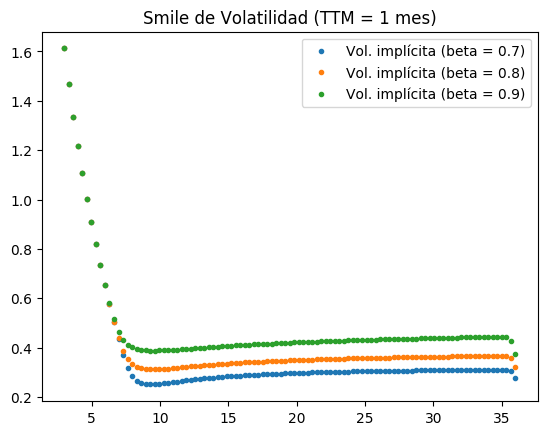

In [22]:
f, ax =plt.subplots()
ax.plot(strike_grid, implicit_vols_07, '.', label = 'Vol. implícita (beta = 0.7)')
ax.plot(strike_grid, implicit_vols_08, '.', label = 'Vol. implícita (beta = 0.8)')
ax.plot(strike_grid, implicit_vols_09, '.', label = 'Vol. implícita (beta = 0.9)')
ax.legend()
plt.title('Smile de Volatilidad (TTM = 1 mes)')


# metamos beta = 1


### 4.2 Vencimiento: 3 meses   ($\beta = 0.7, 0.8, 0.9)$



In [23]:
# b) Vencimiento: 3 meses
TTM = 3/12


# b.1) beta = 0.7
beta = 0.7
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_07 = smile(option_TTM, Spot, strike_grid, TTM, inicio)


# b.2) beta = 0.8
beta = 0.8
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_08 = smile(option_TTM, Spot, strike_grid, TTM, inicio)



# b.2) beta = 0.9
beta = 0.9
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.4
implicit_vols_09 = smile(option_TTM, Spot, strike_grid, TTM, inicio)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Text(0.5, 1.0, 'Smile de Volatilidad (TTM = 3 meses)')

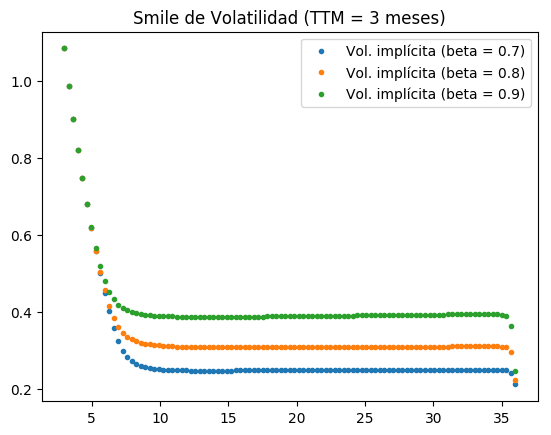

In [24]:
f, ax =plt.subplots()
ax.plot(strike_grid, implicit_vols_07, '.', label = 'Vol. implícita (beta = 0.7)')
ax.plot(strike_grid, implicit_vols_08, '.', label = 'Vol. implícita (beta = 0.8)')
ax.plot(strike_grid, implicit_vols_09, '.', label = 'Vol. implícita (beta = 0.9)')
ax.legend()
plt.title('Smile de Volatilidad (TTM = 3 meses)')

### 4.3 Vencimiento: 6 meses   ($\beta = 0.7, 0.8, 0.9)$

In [27]:
# a) Vencimiento: 6 meses
TTM = 6/12


# b.1) beta = 0.7
beta = 0.7
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_07 = smile(option_TTM, Spot, strike_grid, TTM, inicio)


# b.2) beta = 0.8
beta = 0.8
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.5
implicit_vols_08 = smile(option_TTM, Spot, strike_grid, TTM, inicio)



# b.2) beta = 0.9
beta = 0.9
var_ftor = lambda t, k: -1/2*vol*vol*k**(2*beta)

option = Forward_PDE(Spot, TTM, n_time, K_min, K_max, n_strike, vol, drift_ftor, var_ftor, disc)
option_TTM = option[:,-1]

inicio = 0.4
implicit_vols_09 = smile(option_TTM, Spot, strike_grid, TTM, inicio)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Text(0.5, 1.0, 'Smile de Volatilidad (TTM = 6 meses)')

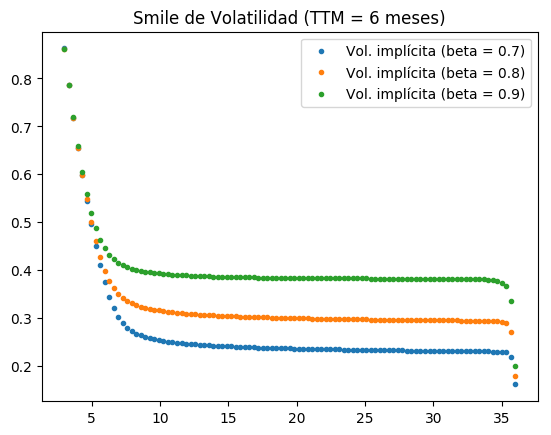

In [28]:
f, ax =plt.subplots()
ax.plot(strike_grid, implicit_vols_07, '.', label = 'Vol. implícita (beta = 0.7)')
ax.plot(strike_grid, implicit_vols_08, '.', label = 'Vol. implícita (beta = 0.8)')
ax.plot(strike_grid, implicit_vols_09, '.', label = 'Vol. implícita (beta = 0.9)')
ax.legend()
plt.title('Smile de Volatilidad (TTM = 6 meses)')